# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

#FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [01:55<00:00, 518File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

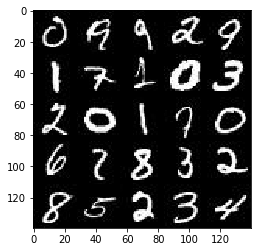

In [1]:

import helper
data_dir = './data'
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

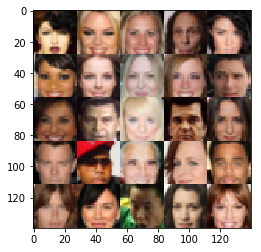

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32)
    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x?
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        #from IPython.core.debugger import Tracer; Tracer()() 
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                       labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #from IPython.core.debugger import Tracer; Tracer()()
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    #from IPython.core.debugger import Tracer; Tracer()()

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    losses = []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2526... Generator Loss: 3.5447
Epoch 1/2... Discriminator Loss: 0.1898... Generator Loss: 16.3951
Epoch 1/2... Discriminator Loss: 2.9844... Generator Loss: 0.0559
Epoch 1/2... Discriminator Loss: 0.0593... Generator Loss: 3.1946
Epoch 1/2... Discriminator Loss: 0.1813... Generator Loss: 8.5370
Epoch 1/2... Discriminator Loss: 0.6990... Generator Loss: 1.8631
Epoch 1/2... Discriminator Loss: 0.6890... Generator Loss: 0.9861
Epoch 1/2... Discriminator Loss: 0.5217... Generator Loss: 1.6288
Epoch 1/2... Discriminator Loss: 0.6979... Generator Loss: 7.6694
Epoch 1/2... Discriminator Loss: 0.2648... Generator Loss: 2.7356


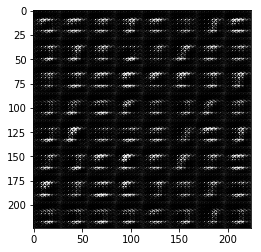

Epoch 1/2... Discriminator Loss: 0.2757... Generator Loss: 2.4159
Epoch 1/2... Discriminator Loss: 0.5532... Generator Loss: 2.7728
Epoch 1/2... Discriminator Loss: 0.8216... Generator Loss: 4.2099
Epoch 1/2... Discriminator Loss: 0.8249... Generator Loss: 1.7395
Epoch 1/2... Discriminator Loss: 0.3187... Generator Loss: 3.0903
Epoch 1/2... Discriminator Loss: 0.5408... Generator Loss: 3.0749
Epoch 1/2... Discriminator Loss: 0.3636... Generator Loss: 2.4482
Epoch 1/2... Discriminator Loss: 1.5312... Generator Loss: 0.5498
Epoch 1/2... Discriminator Loss: 0.7035... Generator Loss: 1.3849
Epoch 1/2... Discriminator Loss: 0.9171... Generator Loss: 1.9460


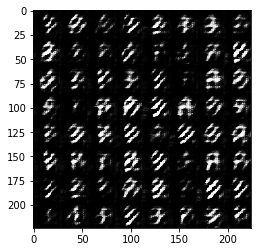

Epoch 1/2... Discriminator Loss: 0.7532... Generator Loss: 1.4021
Epoch 1/2... Discriminator Loss: 0.7933... Generator Loss: 2.2156
Epoch 1/2... Discriminator Loss: 0.3907... Generator Loss: 2.0013
Epoch 1/2... Discriminator Loss: 0.8653... Generator Loss: 0.7392
Epoch 1/2... Discriminator Loss: 1.1337... Generator Loss: 0.7378
Epoch 1/2... Discriminator Loss: 0.5784... Generator Loss: 2.5037
Epoch 1/2... Discriminator Loss: 0.9997... Generator Loss: 3.4614
Epoch 1/2... Discriminator Loss: 0.5963... Generator Loss: 1.1854
Epoch 1/2... Discriminator Loss: 2.3743... Generator Loss: 4.1743
Epoch 1/2... Discriminator Loss: 1.3688... Generator Loss: 0.6642


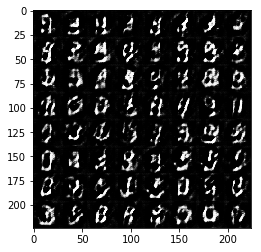

Epoch 1/2... Discriminator Loss: 1.6269... Generator Loss: 2.0088
Epoch 1/2... Discriminator Loss: 0.7056... Generator Loss: 1.2739
Epoch 1/2... Discriminator Loss: 0.6316... Generator Loss: 1.5905
Epoch 1/2... Discriminator Loss: 0.6640... Generator Loss: 2.4446
Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 0.4879
Epoch 1/2... Discriminator Loss: 0.9106... Generator Loss: 2.0932
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 2.9626
Epoch 1/2... Discriminator Loss: 0.9338... Generator Loss: 1.1513
Epoch 1/2... Discriminator Loss: 1.0296... Generator Loss: 1.6173
Epoch 1/2... Discriminator Loss: 1.0405... Generator Loss: 0.7702


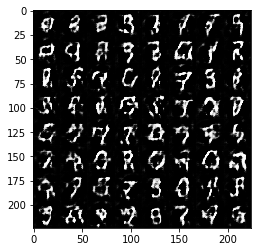

Epoch 1/2... Discriminator Loss: 0.9493... Generator Loss: 1.3201
Epoch 1/2... Discriminator Loss: 1.3785... Generator Loss: 2.7596
Epoch 1/2... Discriminator Loss: 1.4058... Generator Loss: 2.2900
Epoch 1/2... Discriminator Loss: 0.7569... Generator Loss: 1.2628
Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 1.0984
Epoch 1/2... Discriminator Loss: 1.1855... Generator Loss: 1.6325
Epoch 1/2... Discriminator Loss: 1.1447... Generator Loss: 0.7451
Epoch 1/2... Discriminator Loss: 0.8626... Generator Loss: 1.0276
Epoch 1/2... Discriminator Loss: 1.0554... Generator Loss: 0.9852
Epoch 1/2... Discriminator Loss: 0.9045... Generator Loss: 1.0271


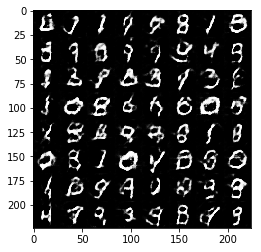

Epoch 1/2... Discriminator Loss: 0.8782... Generator Loss: 1.1126
Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 1.4560
Epoch 1/2... Discriminator Loss: 0.8672... Generator Loss: 1.1320
Epoch 1/2... Discriminator Loss: 1.3022... Generator Loss: 1.3849
Epoch 1/2... Discriminator Loss: 1.1409... Generator Loss: 0.9694
Epoch 1/2... Discriminator Loss: 1.1733... Generator Loss: 0.5992
Epoch 1/2... Discriminator Loss: 1.0739... Generator Loss: 0.8261
Epoch 1/2... Discriminator Loss: 0.8490... Generator Loss: 1.0986
Epoch 1/2... Discriminator Loss: 1.0908... Generator Loss: 0.8914
Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 1.6912


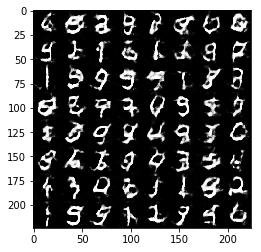

Epoch 1/2... Discriminator Loss: 1.0910... Generator Loss: 0.8077
Epoch 1/2... Discriminator Loss: 1.2083... Generator Loss: 0.5772
Epoch 1/2... Discriminator Loss: 0.9011... Generator Loss: 0.9885
Epoch 1/2... Discriminator Loss: 0.8758... Generator Loss: 1.1429
Epoch 1/2... Discriminator Loss: 0.9882... Generator Loss: 1.1599
Epoch 1/2... Discriminator Loss: 1.4515... Generator Loss: 2.2458
Epoch 1/2... Discriminator Loss: 0.9081... Generator Loss: 1.0490
Epoch 1/2... Discriminator Loss: 1.0597... Generator Loss: 1.5599
Epoch 1/2... Discriminator Loss: 0.9217... Generator Loss: 1.0822
Epoch 1/2... Discriminator Loss: 1.0263... Generator Loss: 0.7583


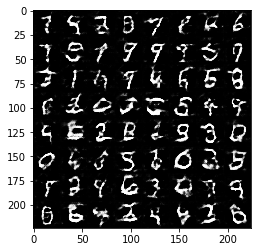

Epoch 1/2... Discriminator Loss: 1.0408... Generator Loss: 1.0378
Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 1.9668
Epoch 1/2... Discriminator Loss: 1.2108... Generator Loss: 1.7807
Epoch 1/2... Discriminator Loss: 1.1109... Generator Loss: 0.6607
Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 1.3036
Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 1.4108
Epoch 1/2... Discriminator Loss: 1.1755... Generator Loss: 0.5700
Epoch 1/2... Discriminator Loss: 1.1457... Generator Loss: 1.1263
Epoch 1/2... Discriminator Loss: 0.9769... Generator Loss: 1.0417
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 1.1397


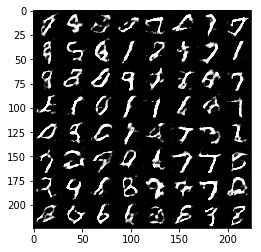

Epoch 1/2... Discriminator Loss: 0.8323... Generator Loss: 1.2140
Epoch 1/2... Discriminator Loss: 1.0646... Generator Loss: 1.2724
Epoch 1/2... Discriminator Loss: 1.1967... Generator Loss: 0.5628
Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 1.6782
Epoch 1/2... Discriminator Loss: 1.4646... Generator Loss: 0.3816
Epoch 1/2... Discriminator Loss: 1.0930... Generator Loss: 1.0646
Epoch 1/2... Discriminator Loss: 1.1879... Generator Loss: 0.6678
Epoch 1/2... Discriminator Loss: 0.9415... Generator Loss: 1.0959
Epoch 1/2... Discriminator Loss: 1.4969... Generator Loss: 0.3706
Epoch 1/2... Discriminator Loss: 1.1169... Generator Loss: 0.6450


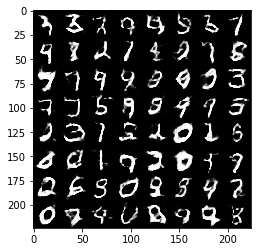

Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 1.2731
Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 1.2270
Epoch 1/2... Discriminator Loss: 1.1033... Generator Loss: 1.4001
Epoch 2/2... Discriminator Loss: 0.8838... Generator Loss: 0.8842
Epoch 2/2... Discriminator Loss: 1.2152... Generator Loss: 0.4588
Epoch 2/2... Discriminator Loss: 1.2768... Generator Loss: 0.5273
Epoch 2/2... Discriminator Loss: 0.9380... Generator Loss: 0.8204
Epoch 2/2... Discriminator Loss: 1.0039... Generator Loss: 0.9353
Epoch 2/2... Discriminator Loss: 0.8803... Generator Loss: 0.8921
Epoch 2/2... Discriminator Loss: 3.4175... Generator Loss: 0.0537


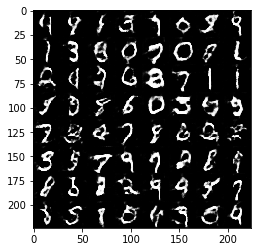

Epoch 2/2... Discriminator Loss: 0.9513... Generator Loss: 0.9699
Epoch 2/2... Discriminator Loss: 0.9895... Generator Loss: 0.9392
Epoch 2/2... Discriminator Loss: 1.0088... Generator Loss: 0.6504
Epoch 2/2... Discriminator Loss: 1.2411... Generator Loss: 0.4588
Epoch 2/2... Discriminator Loss: 0.9845... Generator Loss: 0.7551
Epoch 2/2... Discriminator Loss: 0.9570... Generator Loss: 1.1009
Epoch 2/2... Discriminator Loss: 1.5727... Generator Loss: 0.3624
Epoch 2/2... Discriminator Loss: 0.9178... Generator Loss: 0.7515
Epoch 2/2... Discriminator Loss: 2.4836... Generator Loss: 3.4370
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 0.7968


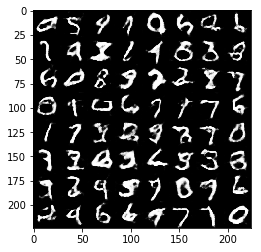

Epoch 2/2... Discriminator Loss: 0.9261... Generator Loss: 1.2083
Epoch 2/2... Discriminator Loss: 0.8686... Generator Loss: 0.8382
Epoch 2/2... Discriminator Loss: 1.6439... Generator Loss: 0.3261
Epoch 2/2... Discriminator Loss: 1.0633... Generator Loss: 0.6771
Epoch 2/2... Discriminator Loss: 0.7655... Generator Loss: 1.0824
Epoch 2/2... Discriminator Loss: 1.0094... Generator Loss: 0.7327
Epoch 2/2... Discriminator Loss: 1.0296... Generator Loss: 1.4981
Epoch 2/2... Discriminator Loss: 0.8622... Generator Loss: 1.3942
Epoch 2/2... Discriminator Loss: 1.0373... Generator Loss: 0.6018
Epoch 2/2... Discriminator Loss: 1.0854... Generator Loss: 0.7334


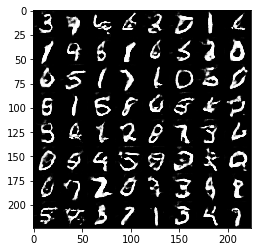

Epoch 2/2... Discriminator Loss: 0.9102... Generator Loss: 1.1043
Epoch 2/2... Discriminator Loss: 1.0915... Generator Loss: 0.6790
Epoch 2/2... Discriminator Loss: 0.9885... Generator Loss: 0.7395
Epoch 2/2... Discriminator Loss: 1.1659... Generator Loss: 0.5224
Epoch 2/2... Discriminator Loss: 1.0796... Generator Loss: 1.4361
Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 0.6549
Epoch 2/2... Discriminator Loss: 0.8435... Generator Loss: 1.1098
Epoch 2/2... Discriminator Loss: 1.2346... Generator Loss: 0.5807
Epoch 2/2... Discriminator Loss: 0.7202... Generator Loss: 1.0960
Epoch 2/2... Discriminator Loss: 0.8047... Generator Loss: 1.1302


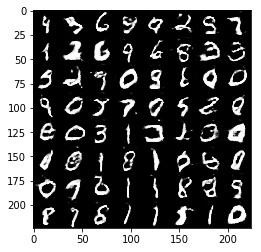

Epoch 2/2... Discriminator Loss: 1.2854... Generator Loss: 0.4742
Epoch 2/2... Discriminator Loss: 1.3526... Generator Loss: 0.4933
Epoch 2/2... Discriminator Loss: 0.9009... Generator Loss: 1.2895
Epoch 2/2... Discriminator Loss: 0.9302... Generator Loss: 1.0633
Epoch 2/2... Discriminator Loss: 0.9149... Generator Loss: 0.7324
Epoch 2/2... Discriminator Loss: 1.0196... Generator Loss: 1.0416
Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 0.7519
Epoch 2/2... Discriminator Loss: 0.6851... Generator Loss: 1.0494
Epoch 2/2... Discriminator Loss: 0.8501... Generator Loss: 1.2639
Epoch 2/2... Discriminator Loss: 0.8827... Generator Loss: 1.7039


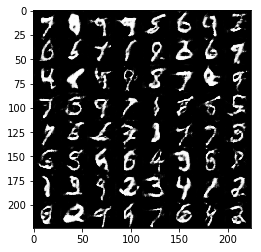

Epoch 2/2... Discriminator Loss: 0.9569... Generator Loss: 0.7411
Epoch 2/2... Discriminator Loss: 1.0229... Generator Loss: 0.6913
Epoch 2/2... Discriminator Loss: 1.0632... Generator Loss: 0.7335
Epoch 2/2... Discriminator Loss: 1.1158... Generator Loss: 0.5648
Epoch 2/2... Discriminator Loss: 1.4346... Generator Loss: 0.4435
Epoch 2/2... Discriminator Loss: 0.6666... Generator Loss: 1.0235
Epoch 2/2... Discriminator Loss: 1.0895... Generator Loss: 0.6442
Epoch 2/2... Discriminator Loss: 3.1307... Generator Loss: 3.7576
Epoch 2/2... Discriminator Loss: 0.7382... Generator Loss: 1.0943
Epoch 2/2... Discriminator Loss: 1.0056... Generator Loss: 0.6225


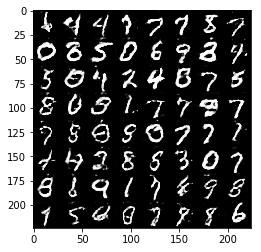

Epoch 2/2... Discriminator Loss: 1.6360... Generator Loss: 0.3656
Epoch 2/2... Discriminator Loss: 0.9233... Generator Loss: 0.7971
Epoch 2/2... Discriminator Loss: 0.5805... Generator Loss: 1.5286
Epoch 2/2... Discriminator Loss: 1.7066... Generator Loss: 0.3117
Epoch 2/2... Discriminator Loss: 0.7380... Generator Loss: 0.9096
Epoch 2/2... Discriminator Loss: 0.9546... Generator Loss: 0.8552
Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 1.1499
Epoch 2/2... Discriminator Loss: 0.7113... Generator Loss: 1.0140
Epoch 2/2... Discriminator Loss: 0.7596... Generator Loss: 2.0601
Epoch 2/2... Discriminator Loss: 1.6352... Generator Loss: 0.4407


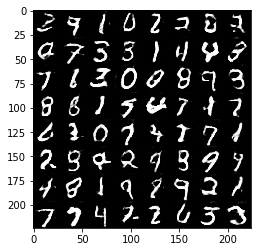

Epoch 2/2... Discriminator Loss: 1.0448... Generator Loss: 0.7111
Epoch 2/2... Discriminator Loss: 0.7096... Generator Loss: 1.4020
Epoch 2/2... Discriminator Loss: 0.7305... Generator Loss: 0.9592
Epoch 2/2... Discriminator Loss: 0.9235... Generator Loss: 0.8768
Epoch 2/2... Discriminator Loss: 1.1323... Generator Loss: 0.6211
Epoch 2/2... Discriminator Loss: 1.0566... Generator Loss: 0.6339
Epoch 2/2... Discriminator Loss: 1.0367... Generator Loss: 1.4557
Epoch 2/2... Discriminator Loss: 0.7402... Generator Loss: 1.0182
Epoch 2/2... Discriminator Loss: 1.3037... Generator Loss: 2.5779
Epoch 2/2... Discriminator Loss: 0.7241... Generator Loss: 1.1184


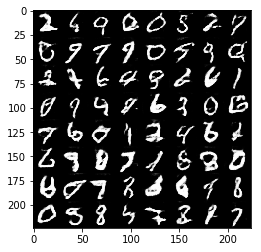

Epoch 2/2... Discriminator Loss: 0.8067... Generator Loss: 0.8625
Epoch 2/2... Discriminator Loss: 0.9369... Generator Loss: 1.2823
Epoch 2/2... Discriminator Loss: 1.0918... Generator Loss: 0.7056
Epoch 2/2... Discriminator Loss: 0.7101... Generator Loss: 1.3586
Epoch 2/2... Discriminator Loss: 0.9156... Generator Loss: 0.7231
Epoch 2/2... Discriminator Loss: 0.6290... Generator Loss: 1.7073
Epoch 2/2... Discriminator Loss: 0.7278... Generator Loss: 1.4516
Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 0.6925
Epoch 2/2... Discriminator Loss: 0.6119... Generator Loss: 1.6415
Epoch 2/2... Discriminator Loss: 0.5998... Generator Loss: 1.4216


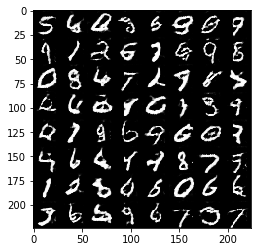

Epoch 2/2... Discriminator Loss: 2.4657... Generator Loss: 4.7223
Epoch 2/2... Discriminator Loss: 1.2210... Generator Loss: 0.5426
Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 0.4856
Epoch 2/2... Discriminator Loss: 0.7796... Generator Loss: 1.7255
Epoch 2/2... Discriminator Loss: 1.3991... Generator Loss: 2.9768
Epoch 2/2... Discriminator Loss: 0.6569... Generator Loss: 1.7025
Epoch 2/2... Discriminator Loss: 0.8943... Generator Loss: 0.7746


IndexError: list index out of range

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0007
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
#from IPython.core.debugger import Tracer; Tracer()()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2170... Generator Loss: 9.1340
Epoch 1/1... Discriminator Loss: 0.3916... Generator Loss: 19.4189
Epoch 1/1... Discriminator Loss: 0.2976... Generator Loss: 14.3347
Epoch 1/1... Discriminator Loss: 0.1827... Generator Loss: 7.1966
Epoch 1/1... Discriminator Loss: 7.3745... Generator Loss: 0.0009
Epoch 1/1... Discriminator Loss: 4.3127... Generator Loss: 10.9871
Epoch 1/1... Discriminator Loss: 0.8106... Generator Loss: 2.4077
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 3.2673
Epoch 1/1... Discriminator Loss: 0.6709... Generator Loss: 4.4792
Epoch 1/1... Discriminator Loss: 0.2150... Generator Loss: 3.3610


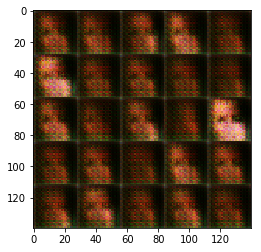

Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 6.5006
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.4971
Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 4.9175
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 2.0474
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 0.5427... Generator Loss: 2.5548
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 4.0036
Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 1.8014
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.6835


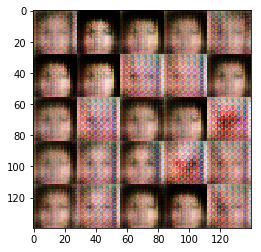

Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 3.1581
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 0.5004... Generator Loss: 1.6831
Epoch 1/1... Discriminator Loss: 0.6467... Generator Loss: 1.2843
Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 1.3374
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 0.7892... Generator Loss: 1.3910
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.5119
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.4901
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 0.9118


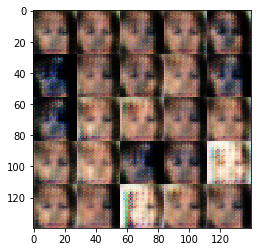

Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 1.8853
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 1.3848
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 2.9164
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 1.2445
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 3.2743
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 2.1197
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 0.7524


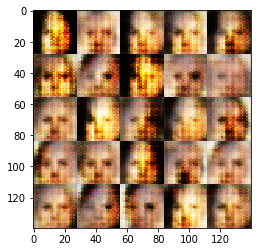

Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 1.8218
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 0.5944... Generator Loss: 1.7176
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.4356
Epoch 1/1... Discriminator Loss: 0.8152... Generator Loss: 3.8376
Epoch 1/1... Discriminator Loss: 0.6012... Generator Loss: 2.1191
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 2.2382
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 1.5233
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.6850


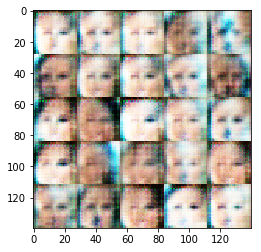

Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 2.3838
Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.2807
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 1.1309
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 2.0213
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.1103
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 1.7479


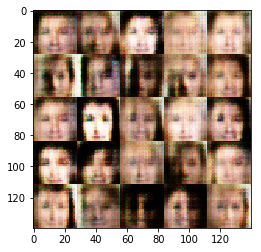

Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.4871
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 1.5888
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.2200
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 2.8192
Epoch 1/1... Discriminator Loss: 0.8663... Generator Loss: 2.4236
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 2.0098... Generator Loss: 0.2492
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 3.1943
Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 1.0083


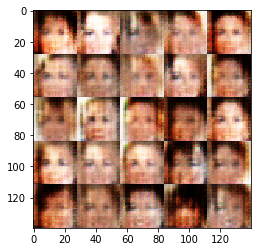

Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 0.8446... Generator Loss: 1.1369
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 0.9739... Generator Loss: 1.9454
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 1.3623
Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.1058
Epoch 1/1... Discriminator Loss: 3.0228... Generator Loss: 0.0756
Epoch 1/1... Discriminator Loss: 0.8442... Generator Loss: 1.0553


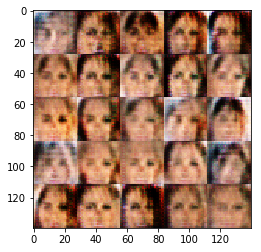

Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 0.7072... Generator Loss: 1.3210
Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 1.1588
Epoch 1/1... Discriminator Loss: 0.7228... Generator Loss: 1.2904
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 1.1623


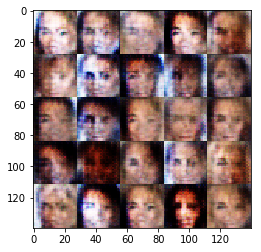

Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.1852
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.2044
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 1.6147... Generator Loss: 0.3698
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 1.3405
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.4884
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.3588


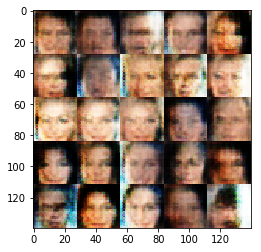

Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.2283
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 1.8354
Epoch 1/1... Discriminator Loss: 0.8323... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.4585
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 1.9626


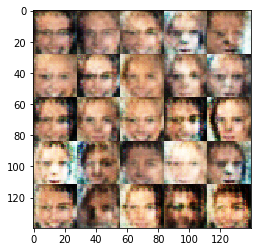

Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 1.1641
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 1.6333
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 1.3481
Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 0.8258


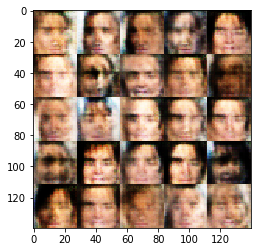

Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 1.2577
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 2.8092... Generator Loss: 3.6189
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 1.7615
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.1591


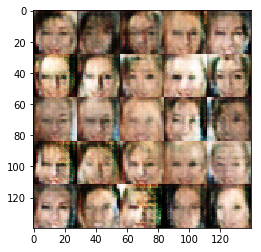

Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.4188
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 2.1830
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 1.4124
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.2280
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 0.4989
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 0.8828... Generator Loss: 1.0912


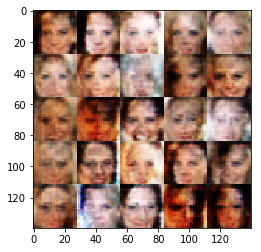

Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.4080
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.3509
Epoch 1/1... Discriminator Loss: 0.8320... Generator Loss: 1.5006
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.4239
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 1.4312
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 1.7282... Generator Loss: 0.2688
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 0.6832


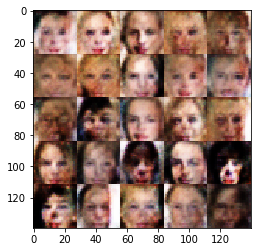

Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 1.0852
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 1.3332
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 1.1993
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 1.3293
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 2.6270
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 0.9838


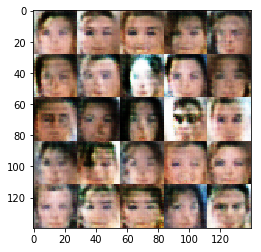

Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.7794... Generator Loss: 0.2609
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.4702
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 2.2016
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 0.8873... Generator Loss: 1.7872
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 0.9471


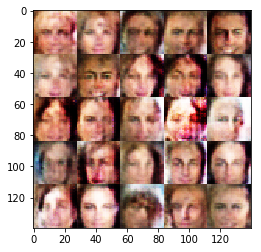

Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.5260
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 1.1737
Epoch 1/1... Discriminator Loss: 0.8106... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 1.2035


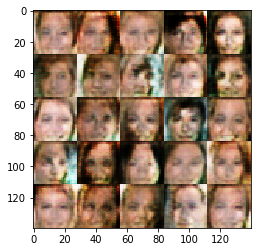

Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 1.2014
Epoch 1/1... Discriminator Loss: 1.6658... Generator Loss: 0.3276
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 1.3776
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 0.8621... Generator Loss: 0.8032


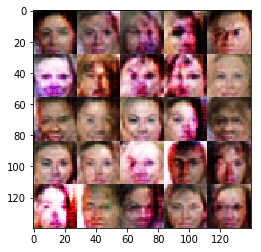

Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 1.2868
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 1.2014
Epoch 1/1... Discriminator Loss: 0.9709... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.2128
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.4828


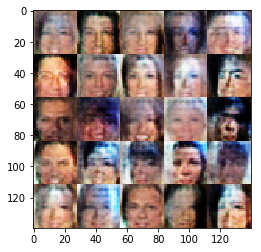

Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 2.6692
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.3365
Epoch 1/1... Discriminator Loss: 0.7559... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.4589
Epoch 1/1... Discriminator Loss: 0.9121... Generator Loss: 1.1306
Epoch 1/1... Discriminator Loss: 0.7429... Generator Loss: 1.4538


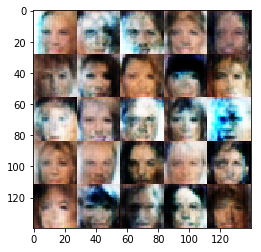

Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 1.2160
Epoch 1/1... Discriminator Loss: 0.8780... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 2.2417
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 0.7470... Generator Loss: 1.2344
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.8585... Generator Loss: 2.5116
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.0840
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.4048


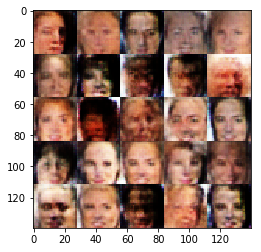

Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 1.7210
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 1.6418
Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 1.3920


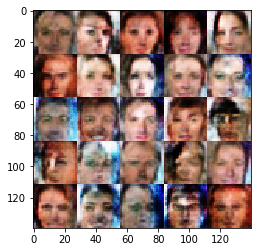

Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 1.1698
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.4948
Epoch 1/1... Discriminator Loss: 0.7118... Generator Loss: 1.5553
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 1.1008
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 1.9808


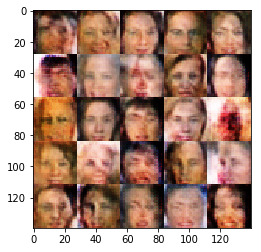

Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 1.8909
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 1.4620
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 1.2658
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 1.1197


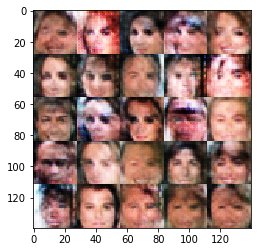

Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 0.3033
Epoch 1/1... Discriminator Loss: 0.7374... Generator Loss: 1.2768
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 1.8139
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.0943


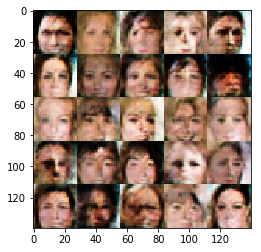

Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 1.0645
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 1.2153
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 1.2482


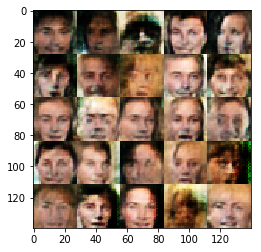

Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.4999
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 1.2887
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 1.2014
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.4637
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.4664
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.5598... Generator Loss: 1.0712
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 2.1386


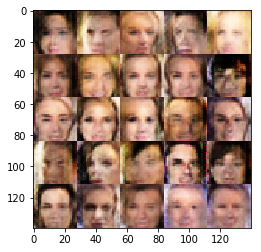

Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 0.7767... Generator Loss: 1.9381
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.3940
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.4243
Epoch 1/1... Discriminator Loss: 0.7551... Generator Loss: 1.1551
Epoch 1/1... Discriminator Loss: 0.9672... Generator Loss: 1.0827


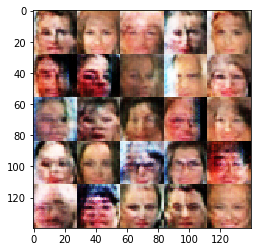

Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.4695
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 1.5898
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 1.0601
Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 1.8917
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.5443


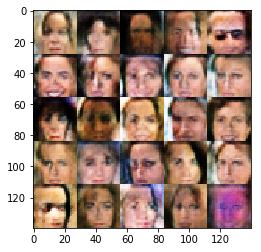

Epoch 1/1... Discriminator Loss: 0.8647... Generator Loss: 1.3385
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 1.3174
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.6589


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0007
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.